In [1]:
%%capture
%%bash

apt install -y libboost-all-dev
pip install -U pip
pip install "pybind11[global]"

pip install aijack

In [2]:
import os
import copy
import random

import kagglehub

import numpy as np
import pandas as pd

from aijack.attack import Poison_attack_sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
random.seed(42)

Загрузим данные

In [4]:
path = kagglehub.dataset_download("dhoogla/distrinetcicids2017")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5


In [5]:
dfps = []

for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps.append(dfp)
            print(dfp)

/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Portscan-DDos-Botnet-Friday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/DoS-Wednesday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Bruteforce-Tuesday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Infiltration-Webattacks-Thursday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Benign-Monday.parquet


In [6]:
print(len(dfps))

5


In [7]:
dfps = [dfp for dfp in dfps if not 'Benign' in dfp]

In [8]:
df = pd.concat([pd.read_parquet(dfp) for dfp in dfps], ignore_index=True)
df.shape

(1436640, 83)

Датасет предназначен для задачи многоклассовой классификации, но мы упростим ее и сведем к бинарной - бинарная классификация на нормальный и аномальный трафик.

In [9]:
target = 'Label'

df[target] = df[target].replace('Attempted-relabel-as-Benign', 'Benign')
df.Label.value_counts() # benign - хороший трафик, остальное - нет

Label
Benign                        1154753
DoS Hulk                       158449
DDoS                            95144
DoS GoldenEye                    7567
Infiltration - Portscan          5485
DoS Slowloris                    3998
FTP-Patator                      3972
SSH-Patator                      2961
DoS Slowhttptest                 1741
Portscan                         1683
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

In [10]:
df.loc[df['Label'] != 'Benign', 'Label'] = 1
df.loc[df['Label'] == 'Benign', 'Label'] = 0

df['Label'] = df['Label'].astype(dtype=np.int32)

df['Label'].value_counts(normalize=True)

Label
0    0.803787
1    0.196213
Name: proportion, dtype: float64

### Train-test split

Для ускорения обучения моделей используем лишь часть данных

In [11]:
X, X_test, y, y_test = train_test_split(
    df.drop(columns=['Label']),
    df['Label'],
    test_size=0.01,
    random_state=42,
)
X, X_train, y, y_train = train_test_split(
    X,
    y,
    test_size=0.05,
    random_state=42,
)
X_train.shape, X_test.shape

((71114, 82), (14367, 82))

### Constant Baseline

Константный бейзлайн в виде самого частотного класса предсказуемо не показывает хорошего качества

In [12]:
roc_auc_score(y_true=y_test, y_score=[0.0]*len(y_test))

0.5

### SVM

Метод опорных векторов, напротив, демонстрирует хорошую производительность...

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = SVC(kernel="linear", C=1, random_state=42)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
roc_auc_score(y_true=y_test, y_score=y_pred)

0.9844379385819594

#### SVC Interpretation

Исползуем:
- Интерпретируйте работу обученной SVC-модели
- Метод Hint

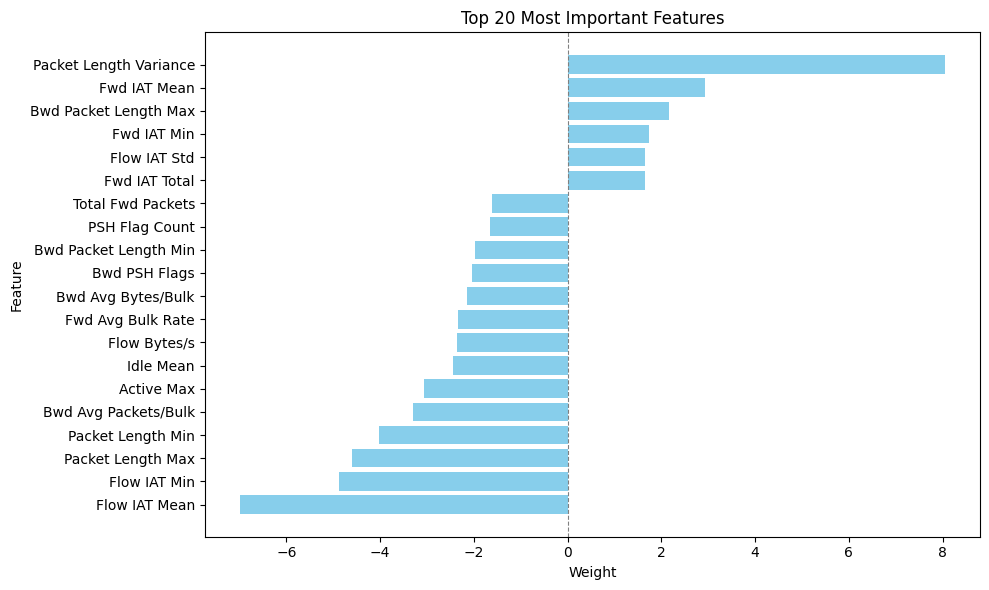

In [14]:
import matplotlib.pyplot as plt

# Extracting and processing model coefficients
coef = model.coef_.ravel()
feature_importance = (
    pd.DataFrame({
        'Feature': X_train.columns,
        'Weight': coef
    })
    .assign(AbsWeight=lambda df: df['Weight'].abs())  # Add absolute values for sorting
    .nlargest(20, 'AbsWeight')                       # Select top 20 based on absolute weight
    .sort_values(by='Weight', ascending=True)        # Sort for better visualization
)

# Vizualitation
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Weight'], color='skyblue')
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Add a vertical line for reference
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.tight_layout()  # Reduce extra spacing
plt.show()


#### SVC Attack - Data poison

Выберем объект, который будем "отравлять"

In [15]:
# initial point
initial_idx = 11
xc = copy.deepcopy(X_train_scaled[initial_idx, :])
yc = y_train.iloc[initial_idx]

Создадим небольшие train/test подвыборки для ускорения процесса обучения

In [16]:
train_idx = random.sample(list(range(1, X_train_scaled.shape[0])), 500)
X_train_ = copy.copy(X_train_scaled[train_idx, :])
y_train_ = copy.copy(y_train.iloc[train_idx]).values

In [17]:
test_idx = random.sample(list(range(1, X_test_scaled.shape[0])), 500)
X_test_ = copy.copy(X_test_scaled[test_idx, :])
y_test_ = copy.copy(y_test.iloc[test_idx]).values

aijack ожидает, что метки классов будут иметь вид 1/-1

In [18]:
y_train_ = np.where(y_train_ == 1, 1, -1)
y_test_ = np.where(y_test_ == 1, 1, -1)

Создайте attacker и "отравленный" объект

In [19]:
print("Forma de xc:", xc.shape)
print("Valor de yc:", yc)
print("Forma de X_train_:", X_train_.shape)
print("Forma de y_train_:", y_train_.shape)
print("Forma de X_test_:", X_test_.shape)
print("Forma de y_test_:", y_test_.shape)
print("Valores únicos en y_train_:", np.unique(y_train_))
print("Valores únicos en y_test_:", np.unique(y_test_))

Forma de xc: (82,)
Valor de yc: 0
Forma de X_train_: (500, 82)
Forma de y_train_: (500,)
Forma de X_test_: (500, 82)
Forma de y_test_: (500,)
Valores únicos en y_train_: [-1  1]
Valores únicos en y_test_: [-1  1]


In [20]:
yc

0

Алгоритм ожидает, что метки будут -1 или 1, но здесь у нас есть 0. Это может вызвать несоответствие во внутренних вычислениях.

In [21]:
"""print("Primeros elementos de X_train_:", X_train_[:5])
print("Primeros elementos de X_test_:", X_test_[:5])
print("Primeros elementos de y_train_:", y_train_[:5])
print("Primeros elementos de y_test_:", y_test_[:5])"""

'print("Primeros elementos de X_train_:", X_train_[:5])\nprint("Primeros elementos de X_test_:", X_test_[:5])\nprint("Primeros elementos de y_train_:", y_train_[:5])\nprint("Primeros elementos de y_test_:", y_test_[:5])'

In [22]:
yc = 1 if yc == 0 else -1 #solution [-1,1]
# Create object attacker
attacker = Poison_attack_sklearn(
    target_model=SVC(kernel="linear", C=1, random_state=42),
    X_train=X_train_,
    y_train=y_train_,
    t = 0.2
)
# Atack
xc_attacked, log = attacker.attack(
    xc=xc,
    yc=yc,
    X_valid=X_test_,
    y_valid=y_test_,
    num_iterations=200
)

Посмотрим, насколько будет падать качество классификации до и после добавления "отравленного" объекта в модель

In [23]:
clf = SVC(kernel="linear", C=1, random_state=42)
clf.fit(X_train_, y_train_)
print("before attack: ", roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)))

# add poinsoned data
clf = SVC(kernel="linear", C=1, random_state=42)
clf.fit(
    np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
    np.concatenate([y_train_, [-1]]),
)

assert roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)) < 0.9769
print("after attack: ", roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)))

before attack:  0.9445720221985292
after attack:  0.9389540446704393


### Random Forest

Обучите модель случайного леса для рещения задачи

In [24]:
%%time
# Обучение модели случайного леса
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
roc_auc_score(y_true=y_test, y_score=rf.predict(X_test))


CPU times: user 27 s, sys: 80.1 ms, total: 27.1 s
Wall time: 27.1 s


0.9974053415065487

#### Random Forest Interpretation

Для интеграции используем:
- permutation_importance
- shap
- lime

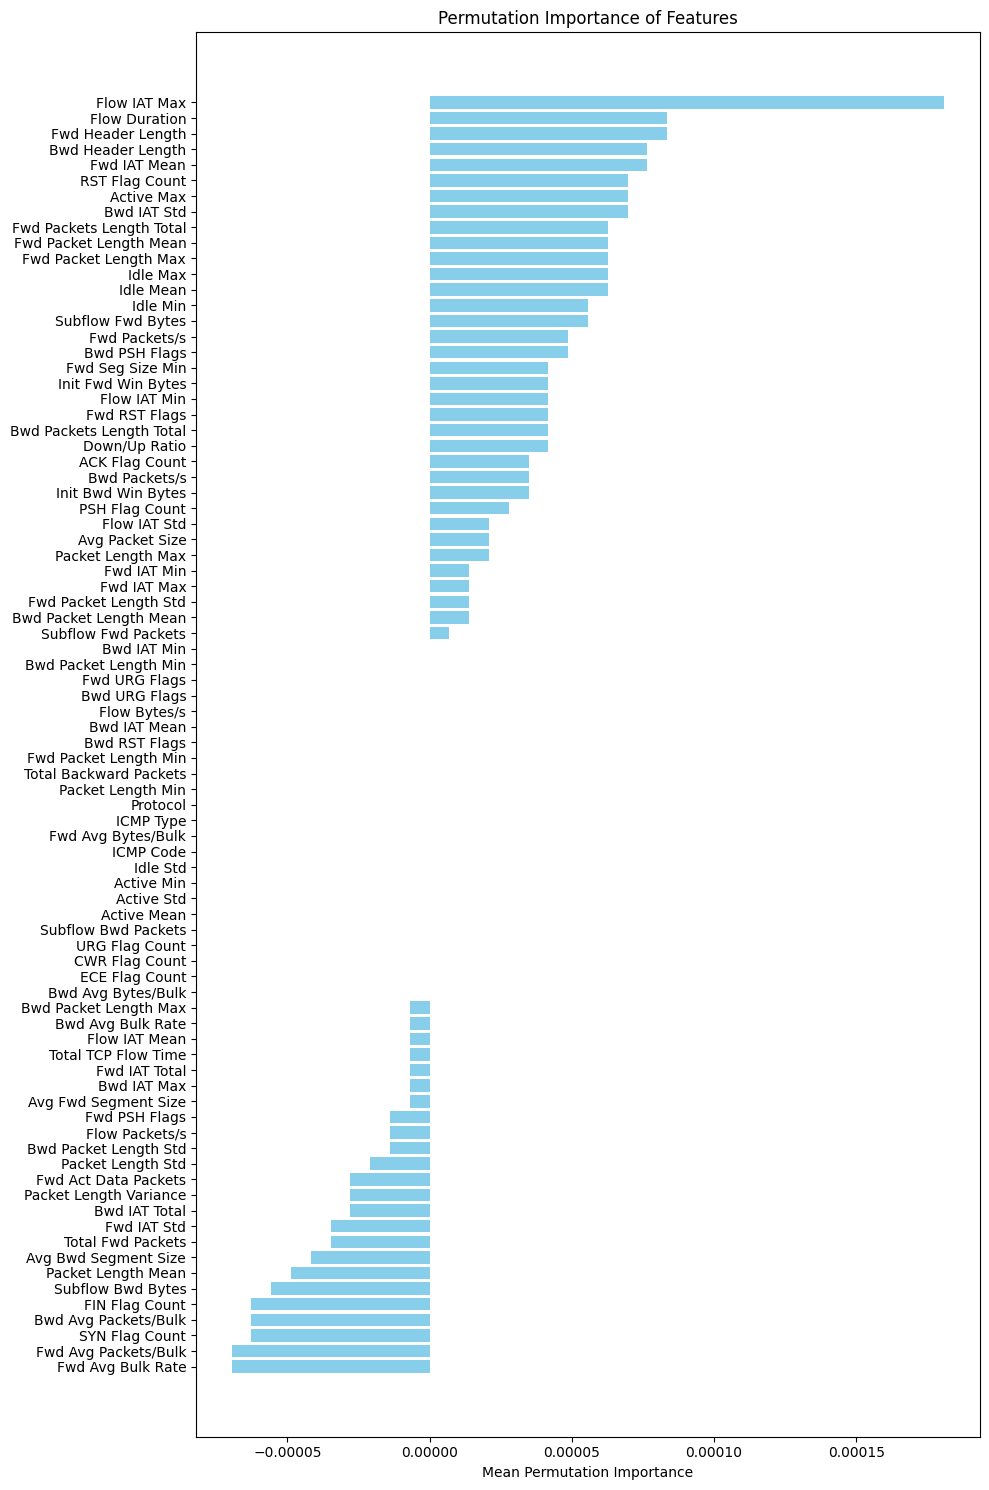

In [25]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Extract the feature importances and sort them
importance_means = perm_importance.importances_mean
sorted_indices = np.argsort(importance_means)

# Plot the results
plt.figure(figsize=(10, 15))
plt.barh(np.array(X_test.columns)[sorted_indices], importance_means[sorted_indices], color='skyblue')
plt.xlabel("Mean Permutation Importance")
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

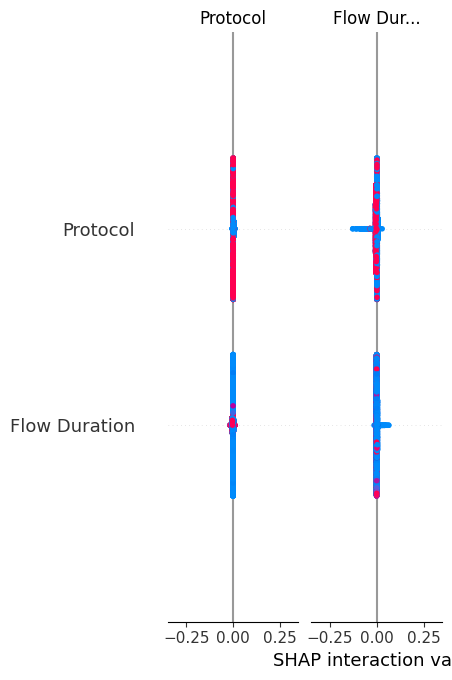

In [26]:
import shap

# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Visualization
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [27]:
%%capture
!pip install lime

In [29]:
import lime
import lime.lime_tabular

# Create a LIME explainer object for model interpretation
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Benign', 'Attack'],
    discretize_continuous=True
)

# Interpretation for an instance with class label 0
index = 0  #index 0
explanation = lime_explainer.explain_instance(X_test.iloc[index].values, rf.predict_proba, num_features=10)
explanation.show_in_notebook(show_all=False)

# Interpretation for an instance with class label 1
index = 1  #index 1
explanation = lime_explainer.explain_instance(X_test.iloc[index].values, rf.predict_proba, num_features=10)
explanation.show_in_notebook(show_all=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
